In [96]:
from typing import Optional, Callable, Tuple, List, NoReturn
from functools import partial, reduce

# From the original code snippet : 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.misc
import scipy.io
import scipy.ndimage.filters
import cv2


# Mine :
from scipy import ndimage
import scipy

import skimage as ski
from skimage import io
from skimage import filters

import matplotlib.pyplot as plt
import matplotlib.image as img

import seaborn as sns


###
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

###

In [18]:
# User-defined functions, utils module found in the same directory as Erosion.ipynb
from utils import binarise, side_by_side

In [19]:
plt.rcParams["figure.figsize"] = (10, 10)

In [46]:
def local_sharpening_lap_heq(
    file: str, 
    tilesizes: Tuple[int] = (4, 4),
    verbose: bool = False
) -> Tuple[np.ndarray]:
    """
    """
    #Function for plotting abs:
    pic_n       = 1
    def show_abs(I, plot_title):
        plt.title(plot_title)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(abs(I), cm.gray)

    #Reading of the image into numpy array:
    A0           = io.imread(file, as_gray=True)
    A0          -= np.amin(A0)#map values to the (0, 255) range
    A0          *= 255.0/np.amax(A0)
    if verbose: print('Img         ', np.amax(A0), np.amin(A0))
    #>>> Img          255.0 0.0

    #Kernel for negative Laplacian
    kernel      = np.ones((3,3))*(-1)
    kernel[1,1] = 8

    #Convolution of the image with the kernel:
    Lap        = scipy.ndimage.filters.convolve(A0, kernel)

    #Laplacian now has negative values
    if verbose: print('Original Lap', np.amax(Lap), np.amin(Lap))
    #>>> Original Lap 1151.0 -1166.0

    #Map Laplacian to some new range:
    Laps        = Lap*100.0/np.amax(Lap) #Sharpening factor!
    if verbose: print('Scaled Lap  ', np.amax(Laps), np.amin(Laps))
    #>>> Scaled Lap   100.0 -101.303

    if verbose:
        plt.figure(pic_n)
        pic_n += 1
        plt.subplot(1,2,1)
        show_abs(Lap, 'Laplacian')
        plt.subplot(1,2,2)
        show_abs(Laps, 'Scaled Laplacian')

    A           = A0 + Laps #Add negative Laplacian to the original image

    if verbose: print('SharpImg    ', np.amax(A), np.amin(A))
    #>>> SharpImg     350.917 -81.06

    A = abs(A) #Get rid of negative values
    if verbose: print('SharpImg abs', np.amax(A), np.amin(A))

    A           *= 255.0/np.amax(A)
    if verbose: print('SharpImg after scaling', np.amax(A), np.amin(A))
    #>>> SharpImg abs 350.917 0.0

    # Local Histogram Equalization with OpenCV:
    A_cv2       = A
    A_cv2       = A_cv2.astype(np.uint8)

    clahe       = cv2.createCLAHE(clipLimit=1, tileGridSize=tilesizes)
    A_cv2       = clahe.apply(A_cv2)

    if verbose:
        plt.figure(pic_n)
        pic_n += 1
        plt.subplot(2,1,1)
        plt.hist(A_cv2)
        plt.title('Original Histogram')
        plt.subplot(2,1,2)
        plt.hist(A_cv2)
        plt.title('Locally Equalized Histogram')

        plt.figure(pic_n)
        pic_n += 1
        plt.subplot(1,3,1)
        show_abs(A0, 'Original image')
        plt.subplot(1,3,2)
        show_abs(A, 'Laplacian filtered img')
        plt.subplot(1,3,3)
        show_abs(A_cv2, 'Local Hist equalized img')
        plt.show()
    
    return A0, A_cv2

In [86]:
def gaussian_sharpen(f: np.ndarray, alpha: int = 30) -> np.ndarray:
    """
    """
    blurred_f = ndimage.gaussian_filter(f, 3)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    
    return sharpened

In [32]:
# Prolly wrong :
fx = (255*io.imread("images/edited_p10.png", as_gray=True)).astype(int)
fxi = 255.0 - fx
fxi /= 255.0
fx = 1.0 - fxi 

In [33]:
# Prolly right : 
#Reading of the image into numpy array:
A0           = io.imread("images/edited_p10.png", as_gray=True)
A0          -= np.amin(A0)#map values to the (0, 255) range
A0          *= 255.0/np.amax(A0)

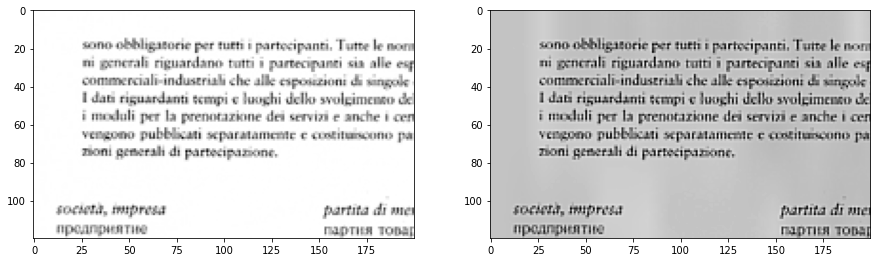

In [83]:
A0, eqA = local_sharpening_lap_heq("images/edited_p11.png", tilesizes=(30, 10))
side_by_side(A0[0:120, 0:200], eqA[0:120, 0:200])

<Figure size 2160x2880 with 0 Axes>

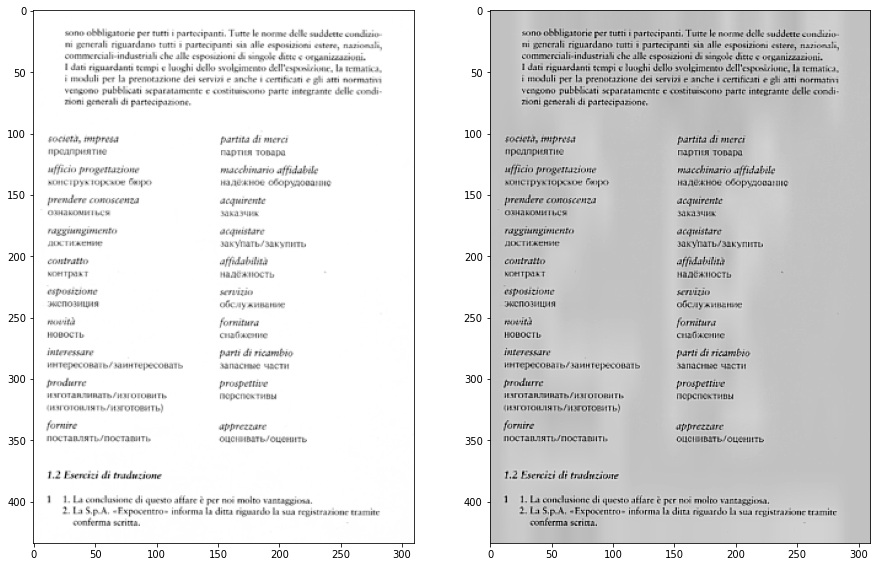

In [93]:
plt.figure(figsize=(30, 40))
side_by_side(A0, eqA)

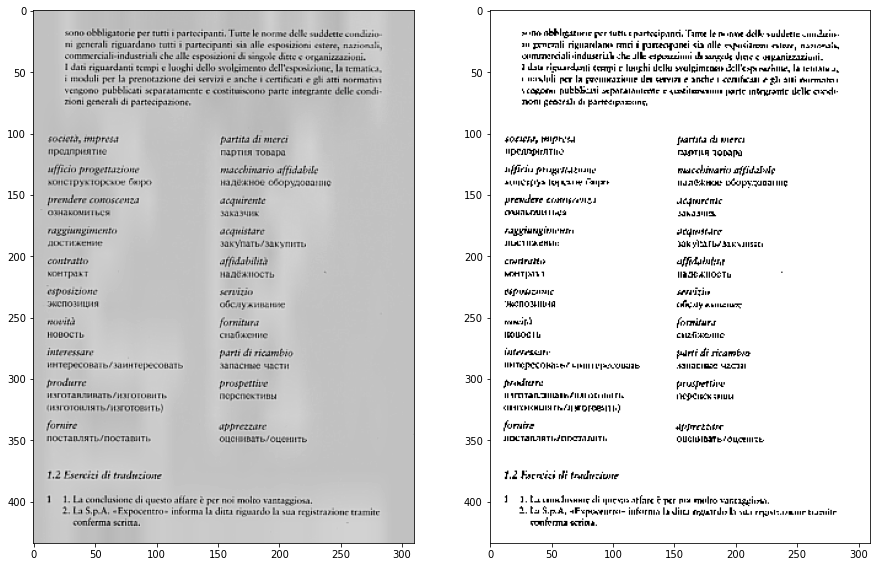

In [100]:
val = filters.threshold_otsu(eqA)
mask = eqA > val
side_by_side(eqA, mask)